In [1]:
# Import necessary packages and libraries to start. 

import pandas as pd
import numpy as np
from numpy import cumsum
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
import scipy
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, acf, pacf
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Using pandas, import dataset into data frame. Drop all NA's from data frame, then preview with head and tail.

df = pd.read_csv('C://Users//cseba//Documents//WGU//D213 Advanced Data Analytics//Data set//teleco_time_series.csv')
df.tail()

,Day,Revenue
726,727,16.931559
727,728,17.490666
728,729,16.803638
729,730,16.194813
730,731,16.620798


In [3]:
# running .info to check type of data, info, and count. There are only 2 columns and confirms that no nulls are present

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Day      731 non-null    int64  
 1   Revenue  731 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 11.5 KB


In [4]:
# display data to find any issues if there are any. There appears to be 731 days total.

pd.set_option("display.max_columns", None)
df

,Day,Revenue
0,1,0.000000
1,2,0.000793
2,3,0.825542
3,4,0.320332
4,5,1.082554
...,...,...
726,727,16.931559
727,728,17.490666
728,729,16.803638
729,730,16.194813


In [5]:
# For the purpose of this analysis and to make the "Day" column easier to understand, apply a specific date for start to 
# finish since the data dictionary mentions that the data is from the first two years of operation, but no dates were given. 
# The only clue we have is that one of the years consisted of a leap year since it is 1 more day than 730 (365 x 2 = 730). 
# Using the clue provided, I will use a random date that includes a leap year.

# But first, create copy of the current df as I will be using this original version of df at a later step.

df2 = df.copy()

# Convert 'Day' column to date starting from 2016-01-01, then applying the numbered day as an equation to the original date
# 2016 was a leap year, meaning years 2016 + 2017 = 731 days. So Starting date will be 1/1/16

start_date = pd.to_datetime('2016-01-01') 

# Calculate the timedelta based on the 'Day' column
# The timedelta is created by subtracting 1 from the 'Day' value 
# (since Day 1 should correspond to 2016-01-01, Day 2 to 2016-01-02, and so forth.)

df2['Date'] = start_date + pd.to_timedelta(df2['Day'] - 1, unit = 'D')

# Drop the original 'Day' column

df2.drop('Day', axis = 1, inplace = True)

# Display the first few rows of the dataset to check the conversion

df2

,Revenue,Date
0,0.000000,2016-01-01
1,0.000793,2016-01-02
2,0.825542,2016-01-03
3,0.320332,2016-01-04
4,1.082554,2016-01-05
...,...,...
726,16.931559,2017-12-27
727,17.490666,2017-12-28
728,16.803638,2017-12-29
729,16.194813,2017-12-30


In [6]:
# Reorder the columns to place the 'Date' column before the 'Revenue'

df2 = df2[['Date', 'Revenue']]

# Display the first few rows of the dataset to check if the reordering applied to the dataset

df2

,Date,Revenue
0,2016-01-01,0.000000
1,2016-01-02,0.000793
2,2016-01-03,0.825542
3,2016-01-04,0.320332
4,2016-01-05,1.082554
...,...,...
726,2017-12-27,16.931559
727,2017-12-28,17.490666
728,2017-12-29,16.803638
729,2017-12-30,16.194813


In [7]:
# check shape of data to confirm number of rows and columns in the data set.

print(df2.shape)

(731, 2)


In [8]:
# apply .describe which will only display numeric type columns, in this case, just Revenue for statistical summary (EDA)
# as the "Date" column was converted to a datetime data type.

df2.describe()

,Revenue
count,731.000000
mean,9.822901
std,3.852645
min,0.000000
25%,6.872836
50%,10.785571
75%,12.566911
max,18.154769


In [9]:
# .info to confirm the two data type columns mentioned in the previous line.

df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     731 non-null    datetime64[ns]
 1   Revenue  731 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 11.5 KB


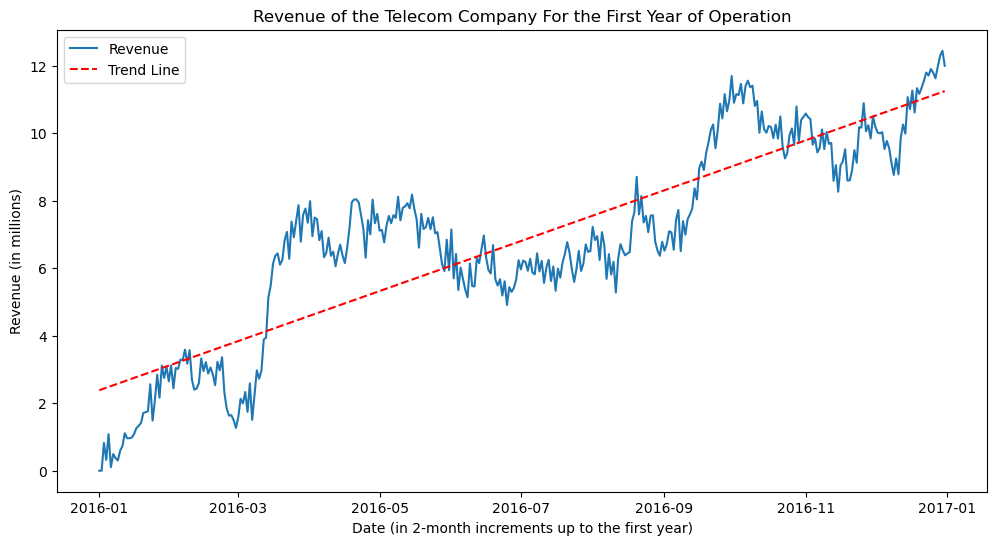

In [10]:
import matplotlib.dates as mdates

# Filter the data to include only the first year as the full 24 months may be too large for this visual.

first_year_data = df2[df2['Date'] < '2017-01-01']

# Plot the revenue data points for year 1.

plt.figure(figsize=(12, 6))
plt.plot(first_year_data['Date'], first_year_data['Revenue'], label='Revenue')

# Apply a trend line to determine the first year's trend over time.

z = np.polyfit(mdates.date2num(first_year_data['Date']), first_year_data['Revenue'], 1)
p = np.poly1d(z)
plt.plot(first_year_data['Date'], p(mdates.date2num(first_year_data['Date'])), "r--", label = 'Trend Line')

# Label the title, x, and y axis, then show. Only the first year is previewed but clearly, the data is trending upwards 
# over time. We need stationarity to more forward with ARIMA.

plt.xlabel('Date (in 2-month increments up to the first year)')
plt.ylabel('Revenue (in millions)')
plt.title('Revenue of the Telecom Company For the First Year of Operation')
plt.legend()
plt.show()

In [11]:
# Re-verify that data is cleaned for the performance assessment by dropping any null columns

df2 = df2.dropna()

In [12]:
# Export the cleaned data to .csv file after dropping nulls

df2.to_csv(r'C://Users//cseba//Documents//WGU//D213 Advanced Data Analytics//Task 1 - Time Series Analysis//clean_dfv2.csv')

In [13]:
# Apply the adf function or the Augmented Dickey-Fuller test in order to make/test the data stationarity.

result = adfuller(df2['Revenue'])

print("Test statistics: ", result[0])
print("p-value: ", result[1])
print("Critical values: ", result[4])

Test statistics:  -1.924612157310181
p-value:  0.3205728150793977
Critical values:  {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}


In [14]:
# Apply if and else statement that will print output that determines stationarity if p-value is less than or equal to 0.05, 
# or else it is non-stationary. 

if result[1]<= 0.05:
    print("Reject null hypothesis, the time series is stationary")
else:
    print("Fail to reject null hypothesis, the time series is non-stationary")

Fail to reject null hypothesis, the time series is non-stationary


In [15]:
# Make the time series stationary with .dff while also dropping NA observations

df_stationary = df2.diff().dropna()

# View the data

df_stationary.head(5)

,Date,Revenue
1,1 days,0.000793
2,1 days,0.824749
3,1 days,-0.505210
4,1 days,0.762222
5,1 days,-0.974900


In [16]:
# Test again using adf on df_stationary to confirm if the time series is stationary with a p-value <= 0.05.

result = adfuller(df_stationary['Revenue'])

print("Test statistics: ", result[0])
print("p-value: ", result[1])
print("Critical values: ", result[4])

if result[1]<= 0.05:
    print("Reject null hypothesis, the time series is stationary")
else:
    print("Fail to reject null hypothesis, the time series is non-stationary")

Test statistics:  -44.874527193876
p-value:  0.0
Critical values:  {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}
Reject null hypothesis, the time series is stationary


Text(0, 0.5, 'Differenced Revenue')

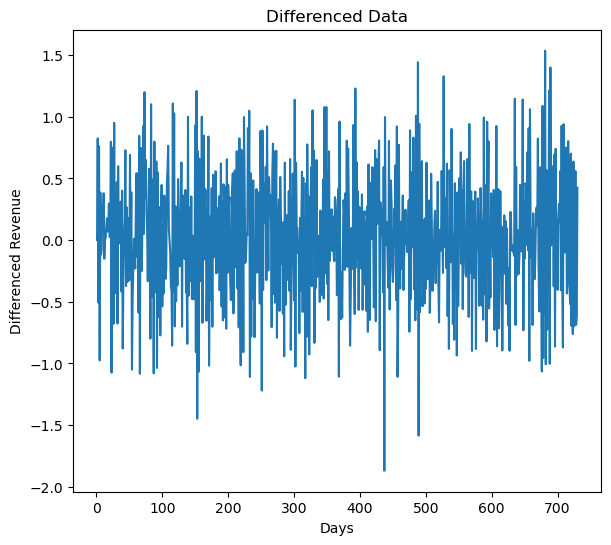

In [17]:
# Plot visualization of difference data to prove stationarity, which centers on zero. This means the value of d is 1, due to
# the data only having to be differenced one time in order to make it stationary.

plt.figure(figsize=(15, 6))
plt.subplot(122)
plt.plot(df_stationary['Revenue'])
plt.title('Differenced Data')
plt.xlabel('Days')
plt.ylabel('Differenced Revenue')

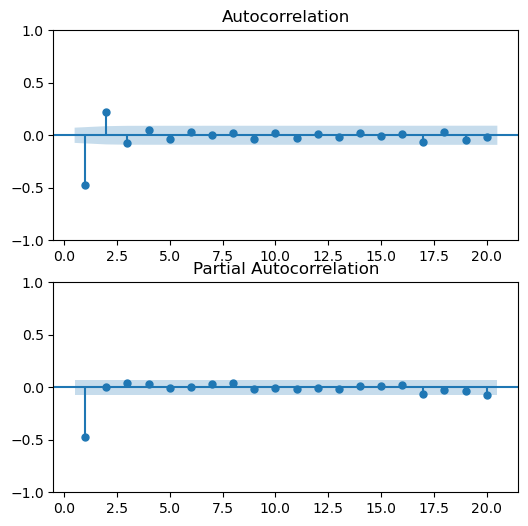

In [18]:
# Now that data is stationary, find pacf and acf
# Use autocorrelation plots to determine the ACF and PACF values
# Import plot_acf and plot_pacf from statsmodels to find the values

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Make figure

fig, (ax1, ax2) = plt.subplots(2,1, figsize = (6,6))

# Plotting the ACF

plot_acf(df_stationary['Revenue'], lags = 20, zero = False, ax = ax1)

# Plotting the PACF

plot_pacf(df_stationary['Revenue'], lags = 20, zero = False, ax = ax2)
plt.show()

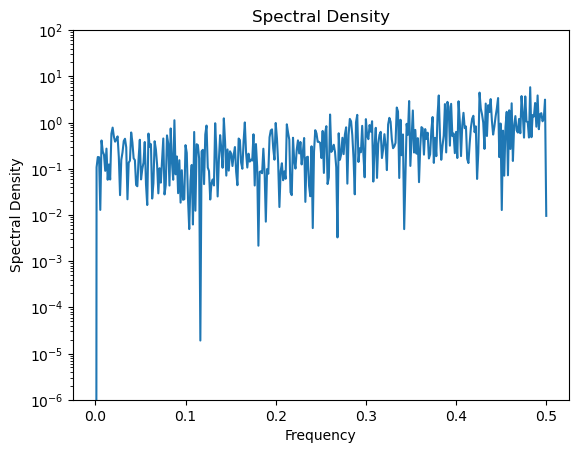

In [19]:
# Based on the graphs on the previous line, pacf = 1 and acf = 1. p,d,q = (1,1,1). Next, run spectral density.
# import signal from scipy for spectral density

from scipy import signal

# Now, run spectral density

f, Pxx_den = signal.periodogram(df_stationary['Revenue'])
plt.semilogy(f, Pxx_den)
plt.ylim([1e-6, 1e2])
plt.title('Spectral Density')
plt.xlabel('Frequency')
plt.ylabel('Spectral Density')
plt.show()

<AxesSubplot:>

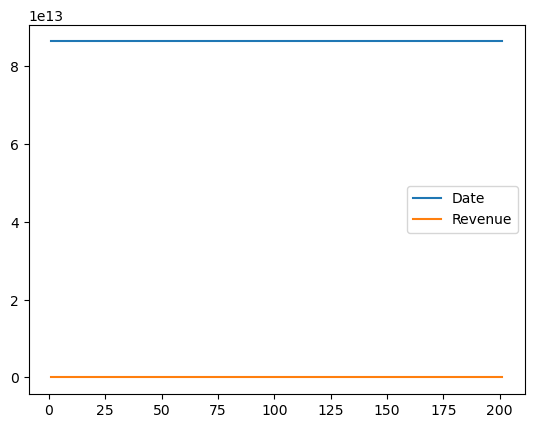

In [20]:
# Now, check for seasonality
# View subset of data to identify seasonality

df_stationary.loc[:'2016-06-30'].plot()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

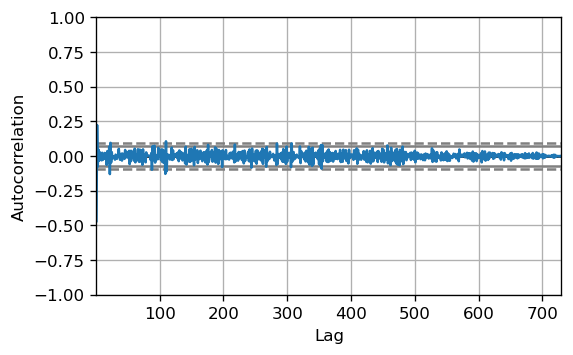

In [21]:
# check for more seasonality

plt.rcParams.update({'figure.figsize':(5,3), 'figure.dpi':120})
autocorrelation_plot(df_stationary.Revenue.tolist())

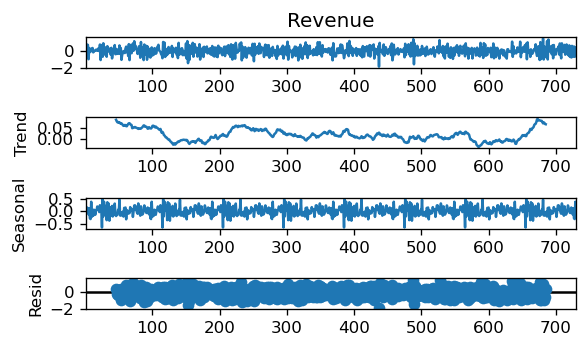

In [22]:
# From here, apply decomposition
# adding the seasonal_decompose function from statsmodels to perform decomposition.

from statsmodels.tsa.seasonal import seasonal_decompose

# Running seasonal decomposition on the data set

decomposition = seasonal_decompose(df_stationary['Revenue'], period = 90)

# Plotting the decomposition 

decomposition.plot()
plt.show()

<AxesSubplot:title={'center':'Seasonality'}>

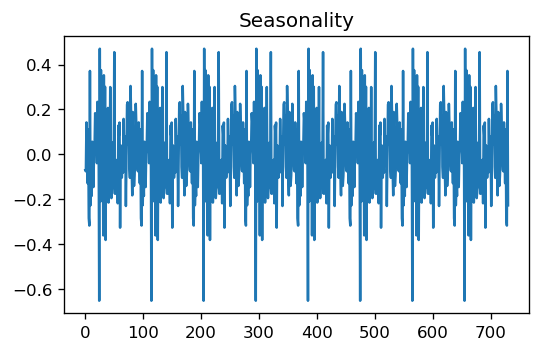

In [23]:
# Plot the seasonality with a more clear and larger visualization

plt.title('Seasonality')
decomposition.seasonal.plot()

<AxesSubplot:title={'center':'Trend'}>

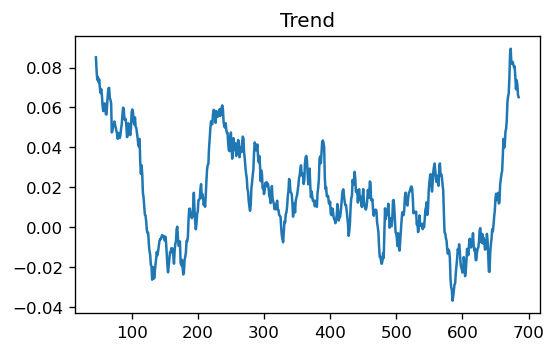

In [24]:
# View larger visualization for trend

plt.title('Trend')
decomposition.trend.plot()

<AxesSubplot:title={'center':'Residual'}>

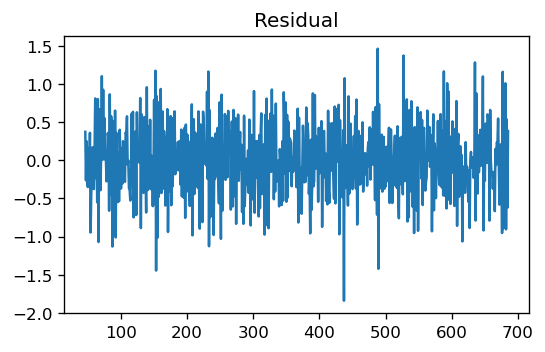

In [25]:
# View larger visualization for the residual

plt.title('Residual')
decomposition.resid.plot()

In [26]:
# With the time series stationary, both pacf and acf observed, and seasonality was tested/performed with decomposition,
# create a train and test split on the original indexed revenue data (df). 
# Also, print the shape of the split data sets and compare it to the full data set to confirm appropriate ratio was applied.

print(df.shape)

train_size = int(len(df) * 0.8)

# Splitting the data
X_train = df.iloc[:train_size]
X_test = df.iloc[train_size:]
print(X_train.shape, X_test.shape)

(731, 2)
(584, 2) (147, 2)


In [27]:
# Export to .csv the train and test sets as required to be submitted for the performance assessment.

X_train.to_csv(r'C://Users//cseba//Documents//WGU//D213 Advanced Data Analytics//Task 1 - Time Series Analysis//trainv2.csv')
X_test.to_csv(r'C://Users//cseba//Documents//WGU//D213 Advanced Data Analytics//Task 1 - Time Series Analysis//testv2.csv')

In [28]:
# Import ARIMA to from statsmodels to run ARIMA and find SARIMAX results

from statsmodels.tsa.arima.model import ARIMA

# Run ARIMA test first time on the training set using original observed p, d, and q values to see results.

p = 1
d = 1
q = 1

model = ARIMA(X_train['Revenue'], order = (p, d, q))
model_fit = model.fit()

# show summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  584
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -385.016
Date:                Mon, 15 Jan 2024   AIC                            776.033
Time:                        02:39:50   BIC                            789.137
Sample:                             0   HQIC                           781.141
                                - 584                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4610      0.078     -5.921      0.000      -0.614      -0.308
ma.L1          0.0041      0.087      0.047      0.962      -0.166       0.174
sigma2         0.2193      0.014     15.948      0.0

In [29]:
# Re-run ARIMA test a 2nd time on the training set using different p, d, and q values to see how SARIMAX results change.

p = 1
d = 2
q = 1

model = ARIMA(X_train['Revenue'], order = (p, d, q))
model_fit = model.fit()

# show summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  584
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -386.927
Date:                Mon, 15 Jan 2024   AIC                            779.854
Time:                        02:39:50   BIC                            792.954
Sample:                             0   HQIC                           784.961
                                - 584                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4596      0.037    -12.564      0.000      -0.531      -0.388
ma.L1         -1.0000      1.867     -0.536      0.592      -4.659       2.659
sigma2         0.2185      0.407      0.537      0.5

In [30]:
# Re-run ARIMA test a 3rd time on the training set using different p, d, and q values to see how SARIMAX results change.

p = 0
d = 2
q = 5

model = ARIMA(X_train['Revenue'], order = (p, d, q))
model_fit = model.fit()

# show summary of the model

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  584
Model:                 ARIMA(0, 2, 5)   Log Likelihood                -385.821
Date:                Mon, 15 Jan 2024   AIC                            783.642
Time:                        02:39:50   BIC                            809.840
Sample:                             0   HQIC                           793.854
                                - 584                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.4594      2.090     -0.698      0.485      -5.556       2.637
ma.L2          0.6989      0.959      0.729      0.466      -1.181       2.579
ma.L3         -0.3084      0.507     -0.609      0.5

In [31]:
# import auto_arima from pmdarima

!pip install pmdarima
from pmdarima import auto_arima
import warnings

# Now, experiement with auto_arima as alternative method to find recommended p, d, q values while also checking
# for seasonality. 

warnings.filterwarnings('ignore')
stepwise_fit = auto_arima(X_train['Revenue'], trace = True, suppress_warnings = True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=776.988, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=910.148, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=773.046, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=798.905, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=909.276, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=775.043, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=775.043, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=776.811, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=774.035, Time=0.03 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.690 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  584
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -383.523
Date:                Mon, 15 Jan 2024   AIC                            773.046
Time:                        02:39:54   BIC                            786.151
Sample:                             0   HQIC                           778.154
                                - 584                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0335      0.019      1.720      0.085      -0.005       0.072
ar.L1         -0.4605      0.036    -12.663      0.000      -0.532      -0.389
sigma2         0.2181      0.014     16.020      0.000       0.191       0.245
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.79
Prob(Q):                              0.96   Prob(JB):                         0.41
Heteroskedasticity (H):               0.97   Skew:                            -0.07
Prob(H) (two-sided):                  0.85   Kurtosis:                         2.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
# Best model parameters determined by auto_arima with an intercept and AIC of 773.046
p = 1
d = 1
q = 0

# Allow a linear trend by setting trend = 't' as indicated by the auto-arima output suggesting a constant after differencing.

model = ARIMA(X_train['Revenue'], order = (p, d, q), trend = 't')
model_fit = model.fit()

# Show summary of the model
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  584
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -383.523
Date:                Mon, 15 Jan 2024   AIC                            773.046
Time:                        02:39:55   BIC                            786.151
Sample:                             0   HQIC                           778.154
                                - 584                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0230      0.013      1.727      0.084      -0.003       0.049
ar.L1         -0.4605      0.036    -12.663      0.000      -0.532      -0.389
sigma2         0.2181      0.014     16.020      0.0

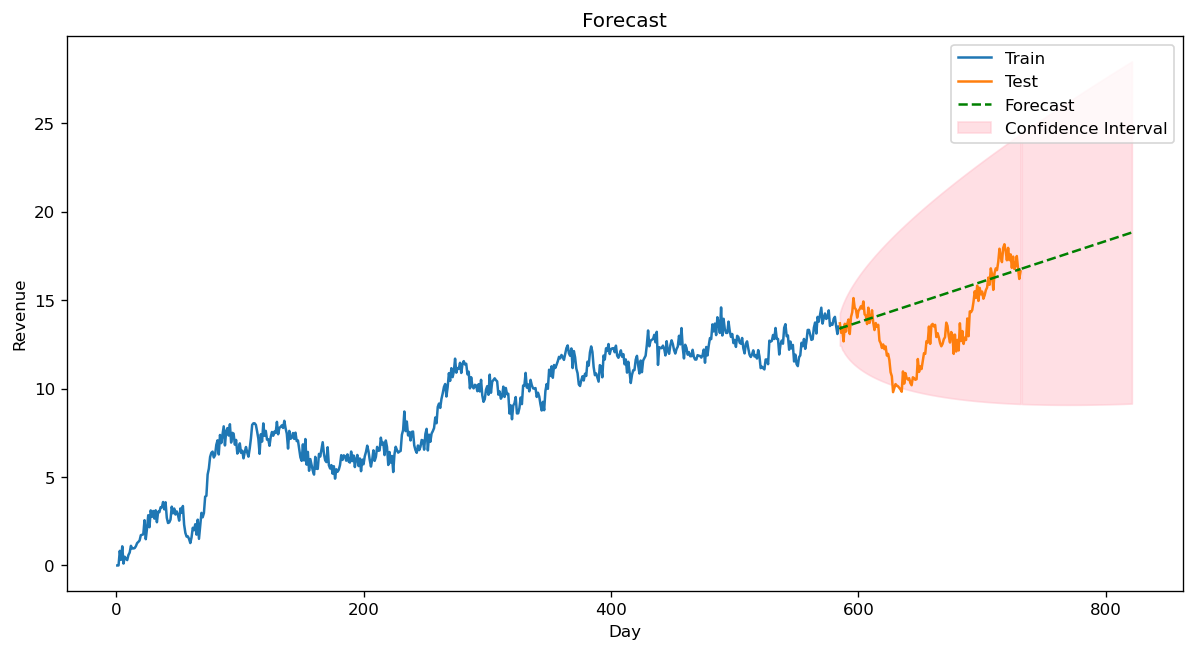

In [33]:
# Calculate the number of steps for forecasting (length of X_test plus another 90 days)

forecast_steps = len(X_test) + 90

# Forecasting from the start of X_test

forecast_start_day = X_test['Day'].iloc[0]

# Forecasting

forecast = model_fit.forecast(steps = forecast_steps)

# Get confidence intervals for the extended forecast

conf_int = model_fit.get_forecast(steps = forecast_steps).conf_int()

# Generating indices for the forecast period starting from the first day of X_test

day_index = pd.RangeIndex(start = forecast_start_day, stop = forecast_start_day + forecast_steps)

# Plot graph

plt.figure(figsize = (12, 6))
plt.plot(X_train['Day'], X_train['Revenue'], label = 'Train')
plt.plot(X_test['Day'], X_test['Revenue'], label = 'Test')

# Plot the forecast

plt.plot(day_index[:len(X_test)], forecast[:len(X_test)], label = 'Forecast', color = 'green', linestyle = 'dashed')

# Plot confidence intervals starting from the beginning of X_test

plt.fill_between(day_index[:len(X_test)], 
                 conf_int.iloc[:len(X_test), 0], 
                 conf_int.iloc[:len(X_test), 1], 
                 label = 'Confidence Interval', color = 'pink', alpha = 0.5)

# Plot the forecast and confidence intervals with extra 90 days

plt.plot(day_index[len(X_test):], forecast[len(X_test):], color = 'green', linestyle = 'dashed')
plt.fill_between(day_index[len(X_test):], 
                 conf_int.iloc[len(X_test):, 0], 
                 conf_int.iloc[len(X_test):, 1], 
                 color = 'pink', alpha = 0.5)

plt.title('Forecast')
plt.xlabel('Day')
plt.ylabel('Revenue')
plt.legend()
plt.show()


In [34]:
# Display lower and upper Revenue range which determined the confidence interval for the forecasting.

conf_int

,lower Revenue,upper Revenue
584,12.428557,14.259375
585,12.411469,14.491726
586,12.188486,14.682632
587,12.093179,14.859764
588,11.967089,15.015226
...,...,...
816,9.141846,28.313354
817,9.144332,28.356778
818,9.146862,28.400159
819,9.149435,28.443497


In [35]:
# Print mean absolute error

mae = np.mean(np.abs(model_fit.resid))
print("Mean absolute error", mae)

Mean absolute error 0.37584555295485417


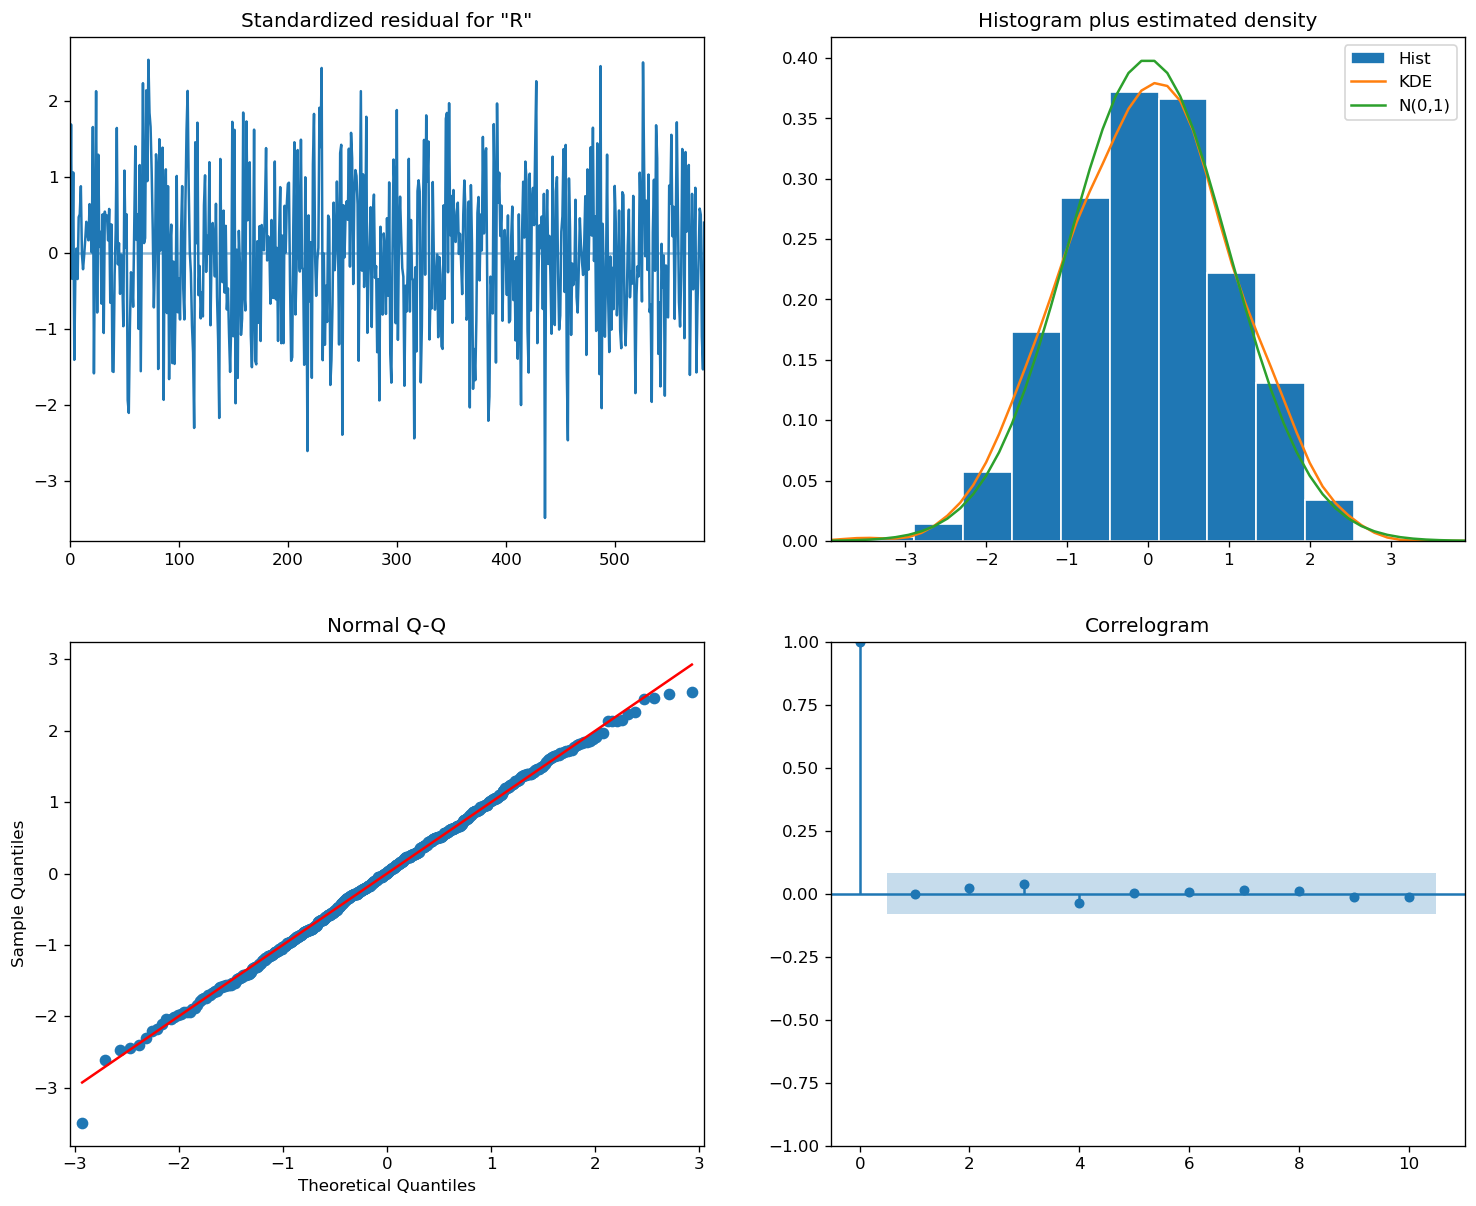

In [36]:
# Create the 4 diagnostics plots for the test

model_fit.plot_diagnostics(figsize = (15, 12)).show()

In [37]:
# Based on auto-ARIMA, the best model:  ARIMA(1,1,0)(0,0,0)[0] intercept with AIC of 773.046
# the second set of numbers confirms no seasonality and a constant trend with intercept. 
# Apply this best model results to the index data set before forecasting and comparing to the plotted train/test forecast


p = 1
d = 1
q = 0

# Fitting the ARIMA model on the indexed data set.

index_model = ARIMA(df['Revenue'], order = (p, d, q), trend = 't')
index_model_fit = index_model.fit()

# show summary of the model

print(index_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  731
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -488.561
Date:                Mon, 15 Jan 2024   AIC                            983.122
Time:                        02:39:55   BIC                            996.901
Sample:                             0   HQIC                           988.438
                                - 731                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0226      0.012      1.898      0.058      -0.001       0.046
ar.L1         -0.4692      0.033    -14.296      0.000      -0.534      -0.405
sigma2         0.2232      0.013     17.801      0.0

In [38]:
# Generate Predictions

prediction = index_model_fit.get_prediction(start = -90)

# Extract prediction mean

mean_prediction = prediction.predicted_mean

# Get confidence intervals of predictions

confidence_intervals = prediction.conf_int()

# Select lower and upper confidence limits

lower_limits = confidence_intervals['lower Revenue']
upper_limits = confidence_intervals['upper Revenue']

confidence_intervals

,lower Revenue,upper Revenue
641,9.654734,11.506638
642,9.546482,11.398387
643,9.351946,11.203851
644,9.532183,11.384087
645,9.716677,11.568582
...,...,...
726,16.195940,18.047844
727,15.958905,17.810810
728,16.335565,18.187470
729,16.233255,18.085160


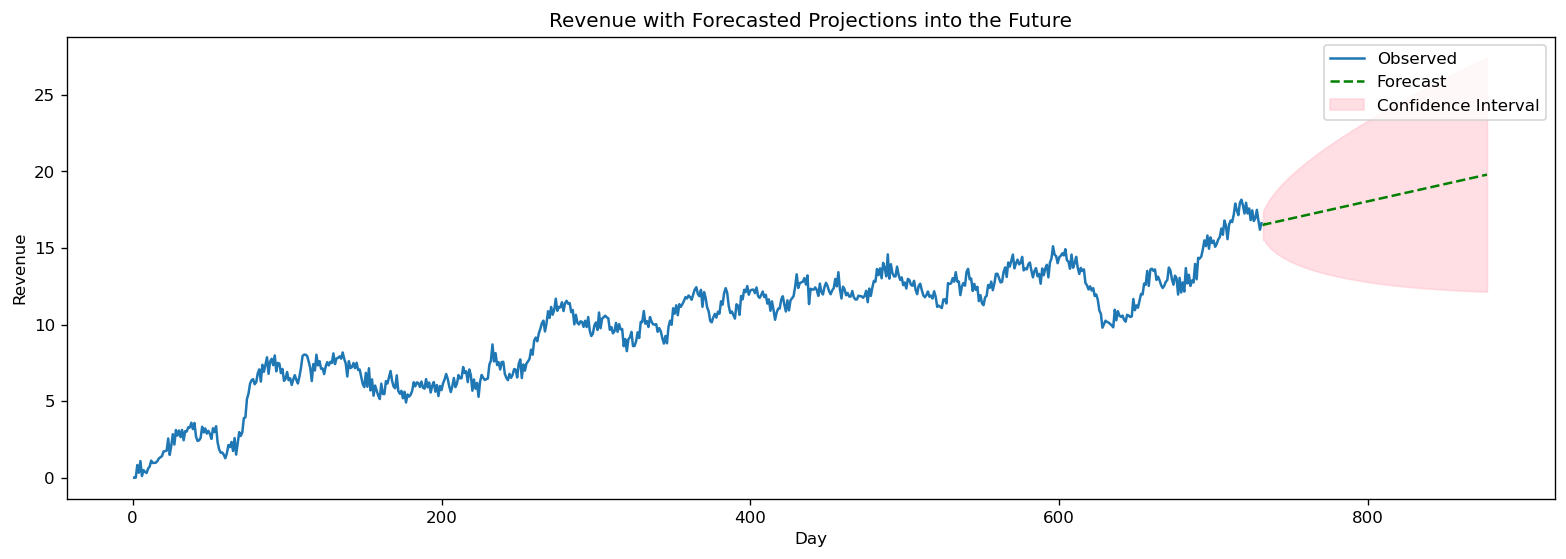

In [39]:
# Calculate the number of steps (integer) for the forecast

forecast_steps = int(len(df) * 0.2)  

# Forecasting

forecast = index_model_fit.forecast(steps = forecast_steps)

# Get confidence intervals
index_conf_int = index_model_fit.get_forecast(steps = forecast_steps).conf_int()

# Extend the existing 'Day' index for the forecast period

last_day = df['Day'].iloc[-1]
extended_day_index = pd.RangeIndex(start = last_day + 1, stop = last_day + 1 + forecast_steps, step = 1)

# Plot the observed data

plt.figure(figsize = (16, 5))
plt.plot(df['Day'], df['Revenue'], label = 'Observed')

# Plot the forecast

plt.plot(extended_day_index, forecast, label = 'Forecast', color = 'green', linestyle = 'dashed')

# Plot confidence intervals

plt.fill_between(extended_day_index, index_conf_int.iloc[:, 0], index_conf_int.iloc[:, 1], 
                 label = 'Confidence Interval', color = 'pink', alpha = 0.5)

# Set labels, legend, and show plot

plt.title('Revenue with Forecasted Projections into the Future')
plt.xlabel('Day')
plt.ylabel('Revenue')
plt.legend()
plt.show()


In [40]:
# Print mean absolute error 

index_mae = np.mean(np.abs(index_model_fit.resid))
print("Mean absolute error", index_mae)

Mean absolute error 0.37965017783817867


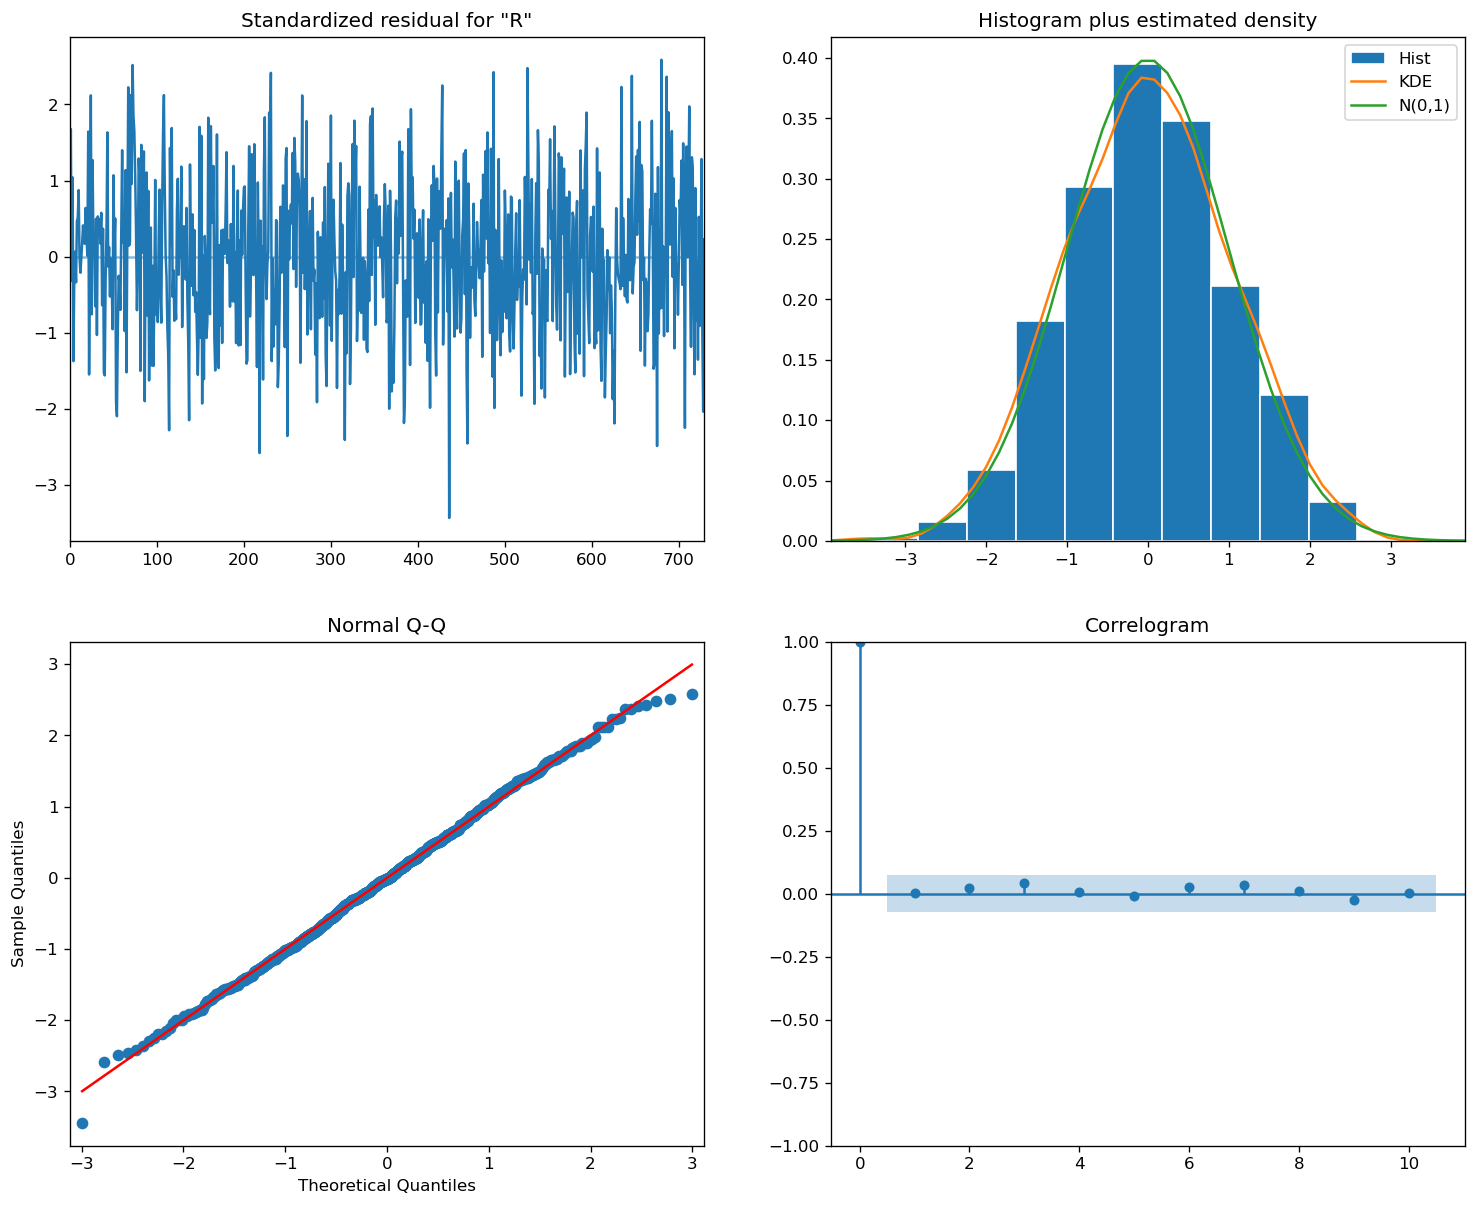

In [41]:
# Create the 4 diagnostics plots for the df

index_model_fit.plot_diagnostics(figsize = (15, 12)).show()

In [42]:
# End of script. 